In [1]:
# Never thought I would see the day:
import numpy as np
from imTools import *
from Taylor08 import *
import time
from MultiScaleRep import *
from Metric import meanSquaresMetric3D
from PIL import Image, ImageOps
from Registration import *

In [2]:
def TaylorMSConvexRegistration(target, base, deformParams, *args):
    
    if len(args) != 0:
        fullScaleFlag = args[0]
    else:
        fullScaleFlag = 1
        
    (window, numScales, bounds, deformType) = deformParams
    
    deformType = deformType.lower()
    bounds = np.array(bounds)
    
    # Set Newton Step Function:
    if len(bounds) == 0:
        NewtonStep = TaylorNSUnconstrained
    else:
        NewtonStep = TaylorNSConstrained
        
    
    P = []
    for i in range(numScales):
        
        scale = 2**((numScales - 1) - i)
        
        if fullScaleFlag == 0:
            if scale == 1:
                break
            
        dsBase = downSample(base, scale)
        dsTarget = downSample(target, scale)
        
        dsWindow = int(np.floor( window / scale ))
        
        if i == 0:
            currentBase = dsBase
        else:
            currentBase = newBase
            
        (pi, zi) = Taylor08(dsTarget, currentBase, deformType, dsWindow, scale, bounds / scale)
        
        
        P.append(-1*pi*scale)
        
        dParams = [sum(P)]

        if deformType == 'gaussian':
            sigma = 10
            dParams.append(sigma)
        if (deformType == 'gaussian') or (deformType == 'thinplate'):
            k = 4
            dParams.append(k)
        
        currentRegistration = deformImage(base, deformType, dParams)
        
        if scale != 1:
            newBase = downSample(currentRegistration, scale/2)
            
        window = int(np.floor(window*(1/3)))
        
        plt.imshow(currentRegistration)
        plt.show()
        
    p = sum(P)
    print('Current Deformation Parameters: ', p, '\n\n')
    return (p, currentRegistration)

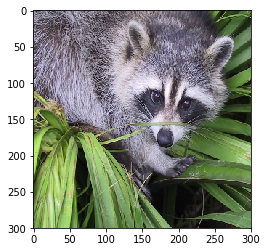

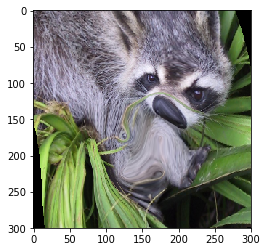

In [2]:
# basePath = 'images/BrainProtonDensitySlice.png'
# targetPath = 'images/BrainProtonDensitySliceShifted13x17y.png'
# targetPath = 'images/BrainProtonDensitySliceR10X13Y17.png'
# targetPath = 'images/DeformedBrainPD.png'
# basePath = 'images/konaResize.png'
# targetPath = 'images/konaRegistered.png'
# basePath = 'images/barn1/im0.ppm'
# targetPath = 'images/barn1/im8.ppm'
# basePath = 'images/BrainMidSagittalSlice.png'
# targetPath = 'images/DefMid.jpg'
basePath = 'images/rice.png'


# base = readImage(basePath, (187, 155))
# basePath = 'images/cat.jpeg'
base = readImage(basePath, (300, 300))
# base = readImage(basePath)
# target = readImage(targetPath)
# target = secondOrderDeformImage(base, [np.random.randn(12)])
pRice = [-4.85652783e+01,  2.13879804e-02,  1.90420182e-01, -1.49591105e+01,
  2.06138188e+01,  4.66034410e+01,  4.46299059e+01,  7.48157007e+01,
 -1.61879635e+01, -7.56041529e+01, -1.04608606e+02, -5.39816481e+01,
 -2.43763083e+01,  4.23189183e+01,  7.17324719e+01,  6.05869523e+01,
  6.65333851e+00,  2.16938729e+01, -2.66608344e+01, -2.06283146e+01,
 -2.29036560e-01,  2.60266203e-01,  3.57578671e+01, -5.17151899e+01,
  1.19845466e+01, -6.05926093e+01,  2.76640916e+01, -2.54377568e+01,
  8.62977308e+01,  3.44749658e+01,  2.03730468e+01, -9.22469569e+01,
 -5.85284555e+01,  1.72526724e+01,  4.11647456e+01,  4.67553022e+01,
 -1.10810954e+01,  2.23931940e+01]
target = gaussianDeformImage(base, [np.array(pRice), 10, 4])
# target = firstOrderDeformImage(base, [[10, -.4, .006, -6, .09, .1]])



(m, n, _) = base.copy().shape
plt.imshow(base)
plt.show()
plt.imshow(target)

In [15]:
baseDS = downSample(base, 2)
targetDS = downSample(target, 2)
start = time.time()
print('Running TaylorMSConvexRegistration...\n\n')
deformParams = (40, 2, [-50, 50, -50, 50], 'gaussian')
(p, rIm) = TaylorMSConvexRegistration(targetDS, baseDS, deformParams, 0)
print('Total Time elapsed: ', (time.time() - start)/60, ' minutes\n\n')

Running TaylorMSConvexRegistration...


Current Deformation Parameters:  [-4.85652783e+01  2.13879804e-02  1.90420182e-01 -1.49591105e+01
  2.06138188e+01  4.66034410e+01  4.46299059e+01  7.48157007e+01
 -1.61879635e+01 -7.56041529e+01 -1.04608606e+02 -5.39816481e+01
 -2.43763083e+01  4.23189183e+01  7.17324719e+01  6.05869523e+01
  6.65333851e+00  2.16938729e+01 -2.66608344e+01 -2.06283146e+01
 -2.29036560e-01  2.60266203e-01  3.57578671e+01 -5.17151899e+01
  1.19845466e+01 -6.05926093e+01  2.76640916e+01 -2.54377568e+01
  8.62977308e+01  3.44749658e+01  2.03730468e+01 -9.22469569e+01
 -5.85284555e+01  1.72526724e+01  4.11647456e+01  4.67553022e+01
 -1.10810954e+01  2.23931940e+01] 


Total Time elapsed:  3.702062249183655  minutes




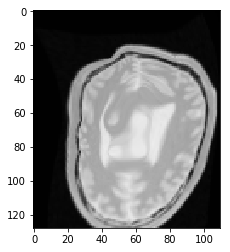

In [16]:
plt.imshow(rIm)

In [20]:
pilIm = Image.fromarray(np.uint8(target))
pilIm.save('/Users/brknight/Documents/ConvexOptimization/figures/WarpedRice.png')

In [ ]:
start = time.time()
deformParams = (40, 3, [-50, 50, -50, 50], 'gaussian')
(p, rIm) = TaylorMSConvexRegistration2(testIm, base, deformParams)
print('Total Time elapsed: ', (time.time() - start)/60, ' minutes\n\n')

In [ ]:
(tIm, tx) = registerImages(base, testIm, 'bspline', 'ms')

In [ ]:
plt.imshow(tIm)

In [ ]:
start = time.time()
deformParams = (40, 3, [-50, 50, -50, 50], 'gaussian')
(p, rIm) = TaylorMSConvexRegistration(tIm, base, deformParams)
print('Total Time elapsed: ', (time.time() - start)/60, ' minutes\n\n')

In [ ]:
def TaylorMSConvexRegistration2(target, base, deformParams):
    
    (window, numScales, bounds, deformType) = deformParams
    
    deformType = deformType.lower()
    bounds = np.array(bounds)
    
    if len(bounds) != 0:
        (lbX, ubX, lbY, ubY) = bounds
        
    P = []
    for i in range(numScales):
        
        scale = 2**((numScales - 1) - i)
        # dsBase = downSample(base, scale)
        dsTarget = downSample(target, scale)
#         if scale == 1:
#             break
            
        dsWindow = int(np.floor( window / scale ))
        
        if i == 0:
            currentBase = downSample(base, scale)
        else:
            currentBase = newBase
            
        (M, N, _) = dsTarget.shape

        if deformType == 'gaussian':
            L = 19
        elif deformType == 'firstorder':
            L = 3
        elif deformType == 'secondorder':
            L = 6
        elif deformType == 'thirdorder':
            L = 10
        else:# default to gaussian
            L = 19
            deformType = 'gaussian'
        

        (Ax, Ay, Iz, b, C) = getConstraintCoeffs(dsTarget, currentBase, dsWindow, scale, deformType)
        z = cvx.Variable(M*N)
        px = cvx.Variable(L)
        py = cvx.Variable(L)

        objective = cvx.Minimize(np.ones(M*N).T @ z)
        
        constraints = [Ax @ C @ px + Ay @ C @ py - Iz @ z - b <= 0]
        if len(bounds) != 0:
            constraints = [Ax @ C @ px + Ay @ C @ py - Iz @ z - b <= 0,
                          C @ px >= lbX/scale*np.ones(M*N),
                          C @ px <= ubX/scale*np.ones(M*N),
                          C @ py >= lbY/scale*np.ones(M*N),
                          C @ py <= ubY/scale*np.ones(M*N)]
            
        prob = cvx.Problem(objective, constraints)

        result = prob.solve(solver=cvx.ECOS)
        
        pi = np.concatenate((px.value, py.value), axis=0)
        
        P.append(-1*pi*scale)
        
        dParams = [sum(P)]

        if deformType == 'gaussian':
            sigma = 10
            dParams.append(sigma)
        if (deformType == 'gaussian') or (deformType == 'thinplate'):
            k = 4
            dParams.append(k)
        
        if scale == 1:
            currentRegistration = deformImage(base, deformType, dParams)
        else:
            currentRegistration = deformImage(base, deformType, dParams)
            newBase = downSample(currentRegistration, scale/2)
        
        window = int(np.floor(window*(1/2.5)))
        
        plt.imshow(currentRegistration)
        plt.show()
    
    p = sum(P)
    
    return (p, currentRegistration)

In [ ]:
deformDictionary = {'gaussian': gaussianD, 
                    'thinplate': thinPlateD,
                    'firstorder': firstOrderD,
                    'secondorder': secondOrderD,
                    'thirdorder': thirdOrderD}

deform = deformDictionary['secondorder']

In [ ]:
plt.imshow(thinPlateDeformImage(base, [1/20000*np.random.randn(38),4]))

In [ ]:
deform((3,4), [np.zeros(12)])

In [ ]:
gaussianD((3,4), [np.zeros(38), 10, 4])

In [ ]:
def TaylorMSConvexRegistration3(target, base, deformParams):
    
    (window, numScales, bounds, deformType) = deformParams
    
    deformType = deformType.lower()
    bounds = np.array(bounds)
    
    # Set Newton Step Function:
    if len(bounds) == 0:
        NewtonStep = TaylorNSUnconstrained
    else:
        NewtonStep = TaylorNSConstrained
        
    
    P = []
    for i in range(numScales):
        
        scale = 2**((numScales - 1) - i)
        if scale == 1:
            break
            
        dsBase = downSample(base, scale)
        dsTarget = downSample(target, scale)
        
        dsWindow = int(np.floor( window / scale ))
        
        if i == 0:
            currentBase = dsBase
        else:
            currentBase = newBase
            
        (pi, zi) = Taylor08(dsTarget, currentBase, deformType, dsWindow, scale, bounds / scale)
        
        dsWindow = int(np.ceil(dsWindow*0.5))
        
        P.append(-1*pi*scale)
        
        dParams = [sum(P)]

        if deformType == 'gaussian':
            sigma = 10
            dParams.append(sigma)
        if (deformType == 'gaussian') or (deformType == 'thinplate'):
            k = 4
            dParams.append(k)
        
        currentRegistration = deformImage(base, deformType, dParams)
        
        currentBase = downSample(currentRegistration, scale)
        
        (pi, zi) = Taylor08(dsTarget, currentBase, deformType, dsWindow, scale, bounds / scale)

        P.append(-1*pi*scale)
        
        dParams = [sum(P)]

        if deformType == 'gaussian':
            sigma = 10
            dParams.append(sigma)
        if (deformType == 'gaussian') or (deformType == 'thinplate'):
            k = 4
            dParams.append(k)
            
        if scale != 1:
            newBase = downSample(currentRegistration, scale/2)
            
        window = int(np.floor(window*(1/2.5)))
        
        plt.imshow(currentRegistration)
        plt.show()
        
    p = sum(P)
    print('Current Deformation Parameters: ', p, '\n\n')
    return (p, currentRegistration)

In [ ]:
# Convex Lower Hull Plot Example
window = 20
plt.imshow(target)
(x,y) = (150,100)
(x,y) = (30,30)
errorSurface = []
stepSize = 2
if window <= 5:
    stepSize = 1
for i in range(-window, window,stepSize):
    for j in range(-window, window,stepSize):

        if ((y + i) < m and (y + i) >= 0 and (x + j) < n and (x + j) >=0):
            error = np.linalg.norm(target[y, x] - base[y + i, x + j], 3) ** 2
            errorSurface.append([i, j, error])

errorSurface = np.array(errorSurface)
# hull = ConvexHull(points = errorSurface, qhull_options='QJ')
# hull = ConvexHull(points = errorSurface)

plotLowerHull(errorSurface, 1)

In [ ]:
def thinPlateD(pix, *args):

    (x,y) = pix

    if len(args[0])!=2:
        kernels = args[0][0]
        scale = 1
    elif len(args[0]) == 2:
        (kernels, scale) = args[0]
    
    print(kernels)
    x *= scale
    y *= scale
    C = [1, x, y]

    for kernel in kernels:
        r = np.linalg.norm(np.array([x, y]) -  np.array(kernel)*scale, 2)
        C.append((r**2)*np.log(r))

    # return int(round(np.dot(C, p)))
    return np.array(C)

In [ ]:
kernels = getKernels((m,n), 4)

In [ ]:
thinPlateD((20,20), [kernels])

In [ ]:
for kernel in kernels:
    print(kernel)

In [ ]:
BW = np.zeros(shape = (50, 50, 3))

In [ ]:
BW[:,:] = [0, 0, 0]

In [ ]:
(rows, cols, _) = BW.shape

for i in range(rows):
    for j in range(cols):
        if j % 2 == 0:
            BW[i , j] = [254, 254, 254]

In [ ]:
plt.imshow(BW)

In [ ]:
BWshifted = firstOrderDeformImage(BW, [[1, 0, 0, 0, 0, 0]])

In [ ]:
plt.imshow(BWshifted.astype(int))

In [ ]:
meanSquaresMetric3D(BW, BWshifted)